# estimate numba over heads

Text(0.5, 0, 'loop count')

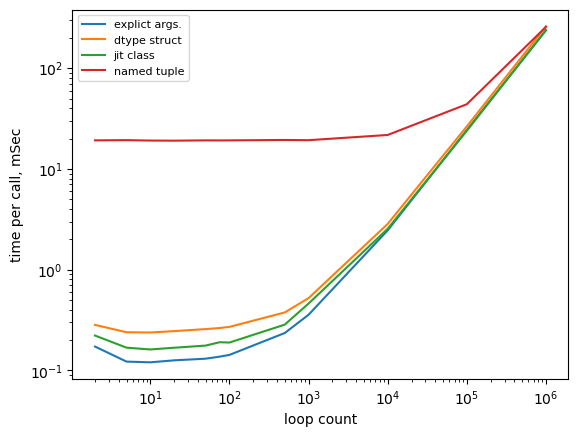

In [18]:
from numba import njit ,types as nbt, typeof, from_dtype
from numba.experimental import jitclass
import numpy as np
from timeit import timeit
from time import perf_counter
from typing import NamedTuple


from oceantracker.util import numpy_util
from oceantracker.util import numba_util
@njit()
def K(a):
    s= 0.
    for n in range(a.size):
        s += np.sin(a[n])*n
    return s


@njit()
def F1(a):
      return K(a)

@njit
def FS(s):
    return K(s['val'])  

@njit
def FC(c):      
    return K(c.val)

@njit    
def FNT(nt):      
    return K(nt.val)

@jitclass([ ('val', nbt.float64[:])])
class ContainerHolder(object):
     def __init__(self, val) -> None:
        self.val = val 

repeats = 100
n_fields = [1,10]
work = np.asarray([2,5,10,20, 50,75, 10**2,500, 10**3,10**4,10**5,10**6],dtype=np.int32)
N= work.size

t1= np.zeros((N,),dtype=np.float64)
tnt= np.zeros((N,),dtype=np.float64)

nfields=np.asarray([1,2,10,20])
ts= np.zeros((N,),dtype=np.float64)
tc= np.zeros((N,),dtype=np.float64)



for n ,w in enumerate(work):
    
    a = np.zeros((w,), dtype=np.float64)
    #print(a)
    #  base case
    F1(a)
    t1[n]=  timeit(lambda  : F1(a),  number =repeats) 

    # base numpy record
    s = np.zeros((1,),dtype=[ ('val', 'f8',a.shape)])[0]
    FS(s) # compile
    ts[n]=  timeit(lambda  : FS(s),  number =repeats)
    
    # base class 
    c= ContainerHolder(a)    
    FC(c) # compile
    tc[n]=  timeit(lambda  : FC(c),  number =repeats)
        
    # named tuple approach
    class NT(NamedTuple):             
        val  : np.ndarray = a 
    nt = NT()
    FNT(nt) # compile     
    tnt[n]=  timeit(lambda  : FNT(nt),  number =repeats) 
       
        
# convert msec    
t1,ts  = 1000*t1, 1000*ts 

tc= 1000*tc  
tnt= 1000*tnt  

from matplotlib import pyplot as plt
fig,ax = plt.subplots()

ax.plot(work,t1,label =f'explict args.')
ax.plot(work,ts,label = f'dtype struct')
ax.plot(work,tc,label = f'jit class')
ax.plot(work,tnt,label =f'named tuple')


plt.xscale('log')
plt.yscale('log')
#ax.plot(ax.get_xlim(),ax.get_xlim(),c=[.8,.8,.8])
ax.legend(prop={'size': 8})
ax.set_ylabel('time per call, mSec')
ax.set_xlabel('loop count')

In [13]:
tnt


array([20.0562, 19.6409, 19.2071, 19.1869, 19.155 , 19.35  , 19.4032,
       19.4116, 19.3655, 20.9272])

Text(0.5, 0, 'loop count')

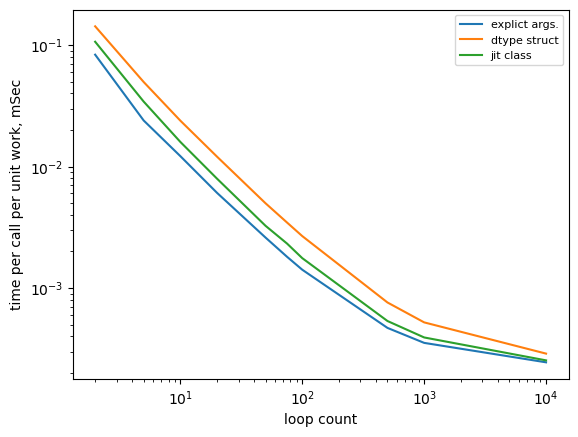

In [14]:
fig,ax = plt.subplots()
ax.plot(work,t1/work,label =f'explict args.')
ax.plot(work,ts/work,label = f'dtype struct')
ax.plot(work,tc/work,label = f'jit class')
#ax.plot(work,tnt/work,label =f'named tuple')
ax.set_xscale('log')
plt.yscale('log')
#ax.plot(ax.get_xlim(),ax.get_xlim(),c=[.8,.8,.8])
ax.legend(prop={'size': 8})
ax.set_ylabel('time per call per unit work, mSec')
ax.set_xlabel('loop count')